# Projeto de Análise Preditiva: Previsão de Preços de Carros Usados (VW Gol)

**Objetivo:** Criar um modelo de Machine Learning para prever o preço de um Volkswagen Gol usado com base em suas características, como ano e quilometragem.

**Fluxo de Trabalho:**
1.  **Coleta de Dados:** Extração de dados de anúncios reais do Mercado Livre via Web Scraping.
2.  **Armazenamento:** Persistência dos dados coletados em um banco de dados MySQL.
3.  **Análise Exploratória (AED):** Limpeza, análise de correlações, distribuições e similaridades entre os dados.
4.  **Modelagem Preditiva:** Construção e avaliação de um modelo de Regressão Linear.
5.  **Visualização:** Apresentação dos resultados e do modelo de forma visual.

In [22]:
# Célula de importação de todas as bibliotecas necessárias
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import os
import json
import mysql.connector
from sqlalchemy import create_engine
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## Fase 1: Coleta de Dados (Web Scraping)

Nesta etapa, vamos extrair os dados diretamente do site do Mercado Livre. Usaremos a biblioteca `requests` para acessar a página e `BeautifulSoup` para parsear o HTML e encontrar as informações de cada anúncio.

In [23]:
url = "https://lista.mercadolivre.com.br/veiculos/carros-caminhonetes/gol"

# Headers para simular um navegador e evitar bloqueios
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36'
}

def limpar_preco(preco_str):
    """Remove 'R$' e pontos de milhar, converte para inteiro."""
    if not preco_str:
        return 0
    # Usa regex para encontrar todos os dígitos
    numeros = re.findall(r'\d+', preco_str)
    return int("".join(numeros)) if numeros else 0

def limpar_km(km_str):
    """Remove 'km' e pontos de milhar, converte para inteiro."""
    if not km_str:
        return 0
    # Usa regex para encontrar todos os dígitos
    numeros = re.findall(r'\d+', km_str)
    return int("".join(numeros)) if numeros else 0

def limpar_ano(string):
    match = re.search(r'(11|12|13|14|15|16|17|18|19|20|21|22|23|24|25)\d{2}', string)

    if match:
       return int(match.group(0))
       return year
    else:
       return None

def get_city_state(localization, arg):
    cidade, estado = localization.split('-')
    if arg == 'cidade':
       return cidade
    if arg == 'estado':
        return estado


In [27]:
try:
    response = requests.get(url, headers=headers, timeout=10)
    response.raise_for_status()  # Verifica se a requisição foi bem sucedida

    print("Requisição bem sucedida! Processando o conteúdo...")
    soup = BeautifulSoup(response.content, 'html.parser')


    anuncios = soup.find_all('div', class_='ui-search-result__wrapper')
    
    dados_carros = []
    for anuncio in anuncios:
        try:
            carro_info = {}

            # --- Extraindo o Título ---
            titulo_element = anuncio.find('a', class_= 'poly-component__title')
            carro_info['titulo'] = titulo_element.text.strip() if titulo_element else 'N/A'
            
            # --- Extraindo o Preço ---
            # O preço está dentro de um span com uma classe específica
            preco_element = anuncio.find('div', class_='poly-component__price')
            preco_str = preco_element.text.strip() if preco_element else '0'
            carro_info['preço'] = limpar_preco(preco_str)
            carro_info['ano'] = limpar_ano(carro_info['titulo']) if titulo_element else 'N/A'

            # --- Extraindo Ano e Quilometragem ---
            # Eles ficam em uma lista de atributos
            atributos_elements = anuncio.find_all('div', class_='poly-component__attributes-list')
            km_str = atributos_elements[0].text.strip() if len(atributos_elements) > 0 else '0'
        
            carro_info['quilometragem'] = limpar_km(km_str)

            # --- Extraindo a Localização ---
            local_element = anuncio.find('span', class_='poly-component__location')
            carro_info['localizacao'] = local_element.text.strip() if local_element else 'N/A' 

            carro_info['cidade'] = get_city_state(carro_info['localizacao'], 'cidade')

            carro_info['estado'] = get_city_state(carro_info['localizacao'], 'estado')
            
            dados_carros.append(carro_info)

        except (AttributeError, IndexError, ValueError) as e:
            # Captura erros se algum campo não for encontrado em um anúncio específico
            print(f"Erro ao processar um anúncio: {e}. Pulando...")
            continue
    
    if dados_carros:
        print("\n--- DADOS EXTRAÍDOS ---")
        print(json.dumps(dados_carros, indent=2, ensure_ascii=False))
        print(f"\nTotal de {len(dados_carros)} carros extraídos com sucesso.")

except requests.exceptions.RequestException as e:
    print(f"Falha na requisição HTTP: {e}")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

df = pd.DataFrame(dados_carros)
print(df.info())
df = df.rename(columns={"preço": "preco"})
df = df.drop('localizacao', axis=1)
#print(df.iloc[[0]])
df.dropna(subset=['ano'], inplace=True)
print(df['ano'])
df['ano'] = df['ano'].astype(int)
df.to_csv('dados_gol_2025.csv', index=False)

Requisição bem sucedida! Processando o conteúdo...

--- DADOS EXTRAÍDOS ---
[
  {
    "titulo": "Volkswagen Gol 2016 1.0 Special Total Flex 5p",
    "preço": 49990,
    "ano": 2016,
    "quilometragem": 50000,
    "localizacao": "Ananindeua - Pará",
    "cidade": "Ananindeua ",
    "estado": " Pará"
  },
  {
    "titulo": "Volkswagen Gol 2013 Gol 1.0 G6 Flex 4p",
    "preço": 30900,
    "ano": 2013,
    "quilometragem": 2013162000,
    "localizacao": "São Sebastião Do Paraíso - Minas Gerais",
    "cidade": "São Sebastião Do Paraíso ",
    "estado": " Minas Gerais"
  },
  {
    "titulo": "Volkswagen Gol 2016 1.0 Special Total Flex 5p",
    "preço": 46900,
    "ano": 2016,
    "quilometragem": 150000,
    "localizacao": "Ananindeua - Pará",
    "cidade": "Ananindeua ",
    "estado": " Pará"
  },
  {
    "titulo": "Volkswagen Gol 2014 Gol 1.0 G6 Trend 4p",
    "preço": 37500,
    "ano": 2014,
    "quilometragem": 2014123500,
    "localizacao": "São Sebastião Do Paraíso - Minas Gerais",
  

## Fase 2: Armazenando os Dados em SQL 


In [28]:
# --- Conexão e Inserção no MySQL ---
# SUBSTITUA COM SUAS CREDENCIAIS
db_user = "root"
db_password = "sua_senha_aqui" 
db_host = "localhost"
db_name = "carros_db"

# Criando a conexão com SQLAlchemy
try:
    engine = create_engine(f"mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}")
    
    # Use o código abaixo para salvar o DataFrame no banco de dados.
    # Descomente a linha df.to_sql para executar a inserção.
    # if_exists='append' adiciona os novos dados sem apagar os antigos.
    
    # df.to_sql(name="anuncios_gol", con=engine, if_exists="append", index=False)
    
    print("Conexão com o banco de dados bem-sucedida.")
    print("Se desejar, descomente a linha 'df.to_sql' para salvar os dados no MySQL.")

except Exception as e:
    print(f"Ocorreu um erro na conexão com o banco de dados: {e}")

Conexão com o banco de dados bem-sucedida.
Se desejar, descomente a linha 'df.to_sql' para salvar os dados no MySQL.


## Fase 3: Análise Exploratória de Dados (AED)

Agora, vamos carregar os dados (do DataFrame em memória, para simplificar) e explorá-los para entender suas características, relações e identificar possíveis outliers.

In [29]:
df = pd.read_csv(os.path.join(os.getcwd(), 'dados_gol_2025.csv'))

# Converte colunas para numérico e tratar NaNs
df['ano'] = pd.to_numeric(df['ano'], errors='coerce')
df['preco'] = pd.to_numeric(df['preco'], errors='coerce')
df = df.dropna(subset=['ano', 'preco', 'quilometragem'])


ano       2018.770833
preco    48164.437500
dtype: float64


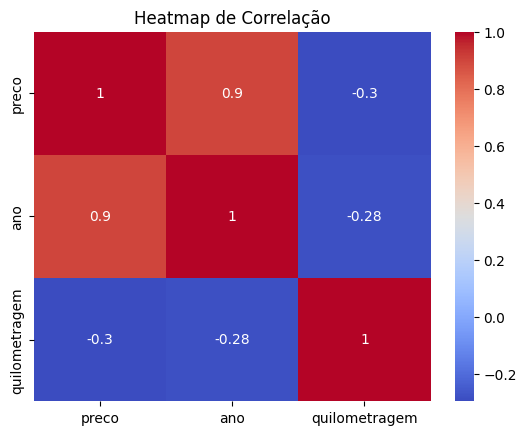

In [34]:
#  Correlação, heatmap e média
colunas_numericas = df.select_dtypes(include='number')
corr = colunas_numericas.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Heatmap de Correlação")
plt.show

mean = df[['ano', 'preco']].mean()
print(mean)

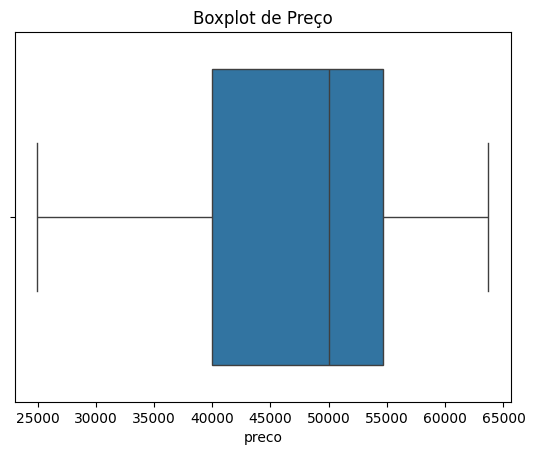

In [31]:
# confirma ausência de outliars
sns.boxplot(x=df['preco'])
plt.title("Boxplot de Preço")
plt.show()

## Fase 4: Preparação para Modelagem e Análise de Similaridade

Antes de construir o modelo, vamos normalizar os dados. Isso coloca todas as variáveis na mesma escala (entre 0 e 1), o que é essencial para algoritmos baseados em distância. Usaremos esses dados normalizados para calcular a "distância" ou "similaridade" entre cada carro.

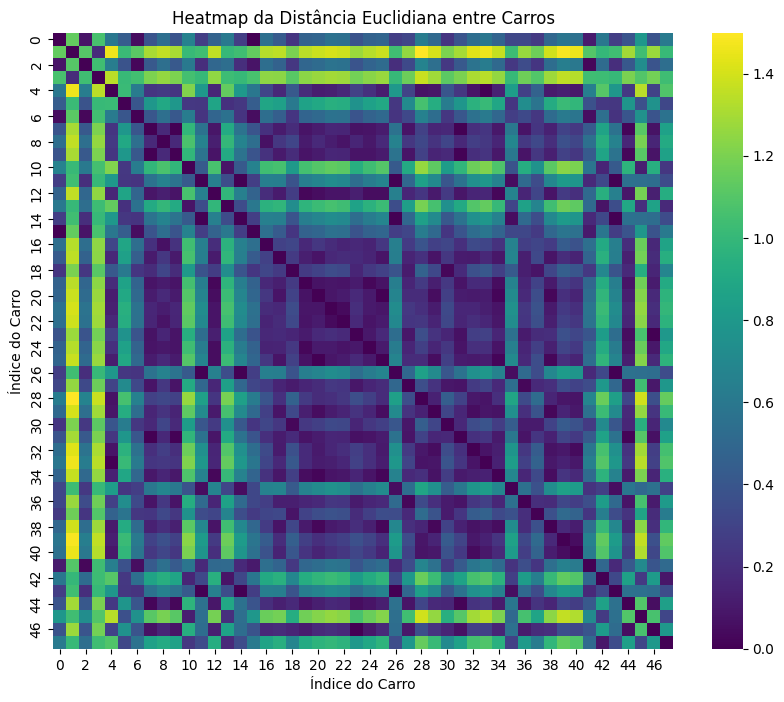

In [40]:
# Normalização das features 'ano' e 'preco'
scaler = MinMaxScaler()
df[['ano_norm', 'preco_norm', 'km_norm']] = scaler.fit_transform(df[['ano', 'preco', 'quilometragem']])

# Matriz de Distância Euclidiana
features = df[['ano_norm', 'preco_norm', 'km_norm']]
dist_matrix = cdist(features, features, metric='euclidean')

# Heatmap da Distância Euclidiana
plt.figure(figsize=(10, 8))
sns.heatmap(dist_matrix, cmap='viridis')
plt.title('Heatmap da Distância Euclidiana entre Carros')
plt.xlabel('Índice do Carro')
plt.ylabel('Índice do Carro')
plt.show()

## Fase 5: Modelagem Preditiva (Regressão Linear)

Finalmente, vamos construir nosso modelo de Regressão Linear. O objetivo é treinar um modelo que aprenda a relação entre o **ano** de um carro e seu **preço**, para que possamos prever o preço de carros com base nessa característica.

In [42]:
# Preparando os dados para o modelo
X = df[['ano']]  # Variável independente (precisa ser um DataFrame)
y = df['preco']   # Variável dependente (o que queremos prever)

# Criando e treinando o modelo de Regressão Linear
model = LinearRegression()
model.fit(X, y)

# Extraindo os resultados do modelo
coef_a = model.coef_[0]
intercept_b = model.intercept_
r2_score = model.score(X, y)

print(f"--- Resultados do Modelo de Regressão ---")
print(f"A equação da reta é: Preço = {coef_a:.2f} * Ano + ({intercept_b:.2f})")
print(f"Coeficiente de Determinação (R²): {r2_score:.4f}")
print(f"Isso significa que {r2_score:.2%} da variação no preço pode ser explicada pelo ano do carro.")

--- Resultados do Modelo de Regressão ---
A equação da reta é: Preço = 2284.68 * Ano + (-4564083.76)
Coeficiente de Determinação (R²): 0.8153
Isso significa que 81.53% da variação no preço pode ser explicada pelo ano do carro.


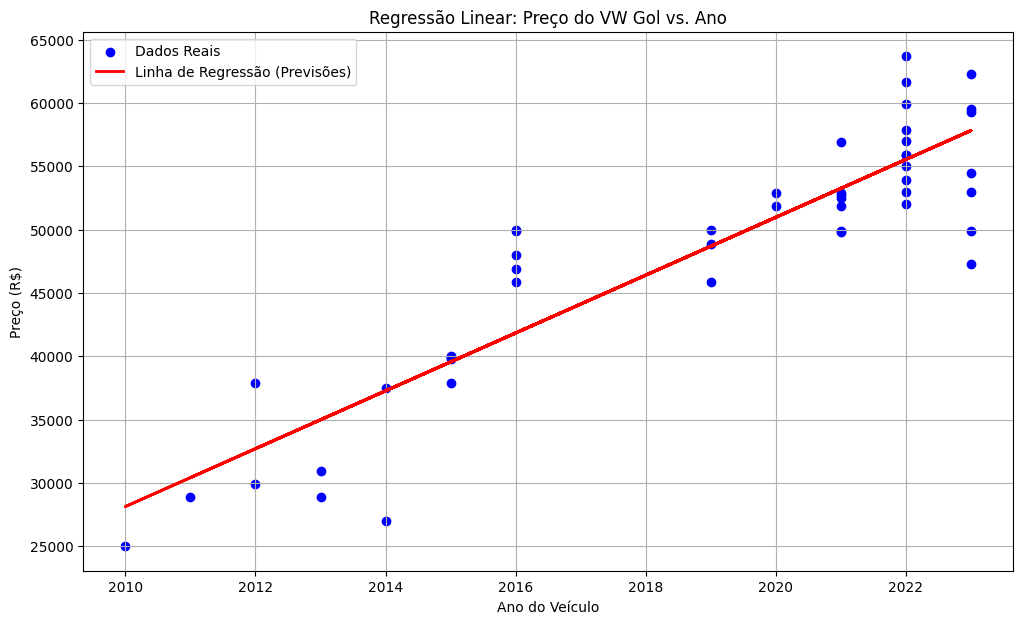

In [43]:
# Visualização do Modelo de Regressão

# Gerando os valores previstos (y chapéu) para a linha de regressão
y_chapeu = model.predict(X)

plt.figure(figsize=(12, 7))

# Gráfico de dispersão com os dados reais
plt.scatter(X, y, color='blue', label='Dados Reais')

# Linha de regressão
plt.plot(X, y_chapeu, color='red', linewidth=2, label='Linha de Regressão (Previsões)')

plt.title('Regressão Linear: Preço do VW Gol vs. Ano')
plt.xlabel('Ano do Veículo')
plt.ylabel('Preço (R$)')
plt.legend()
plt.grid(True)
plt.show()

## Conclusão

Este notebook demonstrou com sucesso um fluxo completo de projeto de dados, desde a coleta de dados brutos da web até a construção e avaliação de um modelo preditivo. O modelo de Regressão Linear mostrou uma forte correlação positiva entre o ano do veículo e seu preço, conforme validado pelo R² e pela visualização gráfica.